In [150]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [140]:
biogrid = pd.read_csv('BIOGRID-ORGANISM-Homo_sapiens-4.4.232.tab3.txt', sep='\t')


C:\Users\annei\AppData\Local\Temp\ipykernel_14876\1437345336.py:1: DtypeWarning: Columns (1,2,18) have mixed types. Specify dtype option on import or set low_memory=False.
  biogrid = pd.read_csv('BIOGRID-ORGANISM-Homo_sapiens-4.4.232.tab3.txt', sep='\t')


In [141]:
biogrid = biogrid[['Official Symbol Interactor A','Official Symbol Interactor B','Score']]
biogrid = biogrid[biogrid['Score'] != '-']
""" Quantitative Score. This will be a positive for negative value recorded by the original publication depicting P-Values, 
    Confidence Score, SGA Score, etc. Will be “-” if no score is reported. """ 
biogrid['Score'] = pd.to_numeric(biogrid['Score'])
biogrid['Score'] = biogrid['Score'].apply(lambda x: 0 if x < 0 else x)
biogrid.reset_index(drop=True, inplace=True)
biogrid.head()

,Official Symbol Interactor A,Official Symbol Interactor B,Score
0,CD2BP2,SNRNP200,1.000
1,GIPC1,MYO6,0.952
2,EIF4A2,EIF4G1,0.931
3,CD2BP2,PRPF8,0.919
4,ARF6,LRPPRC,0.909


In [147]:
biogrid.isna().sum()

Official Symbol Interactor A    0
Official Symbol Interactor B    0
Score                           0
dtype: int64

In [ ]:
""" genesA = biogrid['Official Symbol Interactor A'].tolist()
genesB = biogrid['Official Symbol Interactor B'].tolist()
genes = genesA + genesB
genes = list(dict.fromkeys(genes))
print(genes) """

In [143]:
endometriosis = pd.read_csv('genes_for_protein/ENDOMETRIOSIS.txt', sep = '\t', header=None)
endometriosis = endometriosis.rename(columns={0:'Gene'})

In [144]:

endometriosis.head()

,Gene
0,LACTBL1
1,WNT4
2,GREB1
3,RMND1
4,CCDC170


In [145]:
G = nx.Graph()

for index, row in biogrid.iterrows():
    source_node = row['Official Symbol Interactor A']
    target_node = row['Official Symbol Interactor B']
    score = float(row['Score'])
       
    G.add_edge(source_node, target_node, weight=score)





In [149]:
nodes = endometriosis['Gene'].tolist()
subset_of_nodes = nodes

# Create a new graph to store the shortest paths
H = nx.Graph()

# Find the shortest path between each pair of nodes in the subset
for i in range(len(subset_of_nodes)):
    for j in range(i + 1, len(subset_of_nodes)):
        node_i = subset_of_nodes[i]
        node_j = subset_of_nodes[j]
        
        # Check if both nodes exist in graph G
        if node_i in G and node_j in G:
            try:
                # Calculate shortest path if nodes exist in G
                path = nx.shortest_path(G, node_i, node_j, weight='weight')
                path_edges = [(path[k], path[k+1], {'weight': G[path[k]][path[k+1]]['weight']}) for k in range(len(path)-1)]
                H.add_edges_from(path_edges)
            except nx.NetworkXNoPath:
               # print(f"No path between {node_i} and {node_j}")
                continue
        else:
           # print(f"One or both nodes ({node_i}, {node_j}) not found in graph G. Skipping.")
            continue

# Find the minimum spanning tree of the new graph
mst = nx.minimum_spanning_tree(H, algorithm='kruskal', weight='weight')

# Print the edges of the minimum spanning tree
for edge in mst.edges(data=True):
    node1, node2 = edge[0], edge[1]
    weight = edge[2]['weight']  # Access the weight attribute from edge data
    print(f"Edge: {node1} -- {node2}, Weight: {weight}")


Edge: WNT4 -- HLA-B, Weight: 0.76967376
Edge: HLA-B -- MUSK, Weight: 0.0
Edge: HLA-B -- TMEM70, Weight: 0.791241621
Edge: MUSK -- HSPA1B, Weight: 0.0
Edge: MUSK -- HLA-C, Weight: 0.0
Edge: MUSK -- SEC24B, Weight: 0.0
Edge: MUSK -- SEC23B, Weight: 0.0
Edge: MUSK -- ACBD3, Weight: 0.0
Edge: MUSK -- TFG, Weight: 0.0
Edge: MUSK -- SEC24A, Weight: 0.0
Edge: HSPA1B -- IGF1R, Weight: 0.0
Edge: HSPA1B -- NTRK3, Weight: 0.0
Edge: HSPA1B -- AATK, Weight: 0.0
Edge: HSPA1B -- EPHA10, Weight: 0.0
Edge: HSPA1B -- FGFR2, Weight: 0.0
Edge: HSPA1B -- KDR, Weight: 0.0
Edge: HSPA1B -- MST1R, Weight: 0.0
Edge: HSPA1B -- ALK, Weight: 0.0
Edge: HSPA1B -- EPHB2, Weight: 0.0
Edge: HSPA1B -- EPHA1, Weight: 0.0
Edge: HSPA1B -- LTK, Weight: 0.0
Edge: HSPA1B -- DDR2, Weight: 0.0
Edge: HSPA1B -- FGFR4, Weight: 0.0
Edge: HSPA1B -- FGFR3, Weight: 0.0
Edge: HSPA1B -- LMTK3, Weight: 0.0
Edge: HSPA1B -- EPHA7, Weight: 0.0
Edge: HSPA1B -- MERTK, Weight: 0.0
Edge: HSPA1B -- PDGFRB, Weight: 0.0
Edge: HSPA1B -- ERBB2, Weig

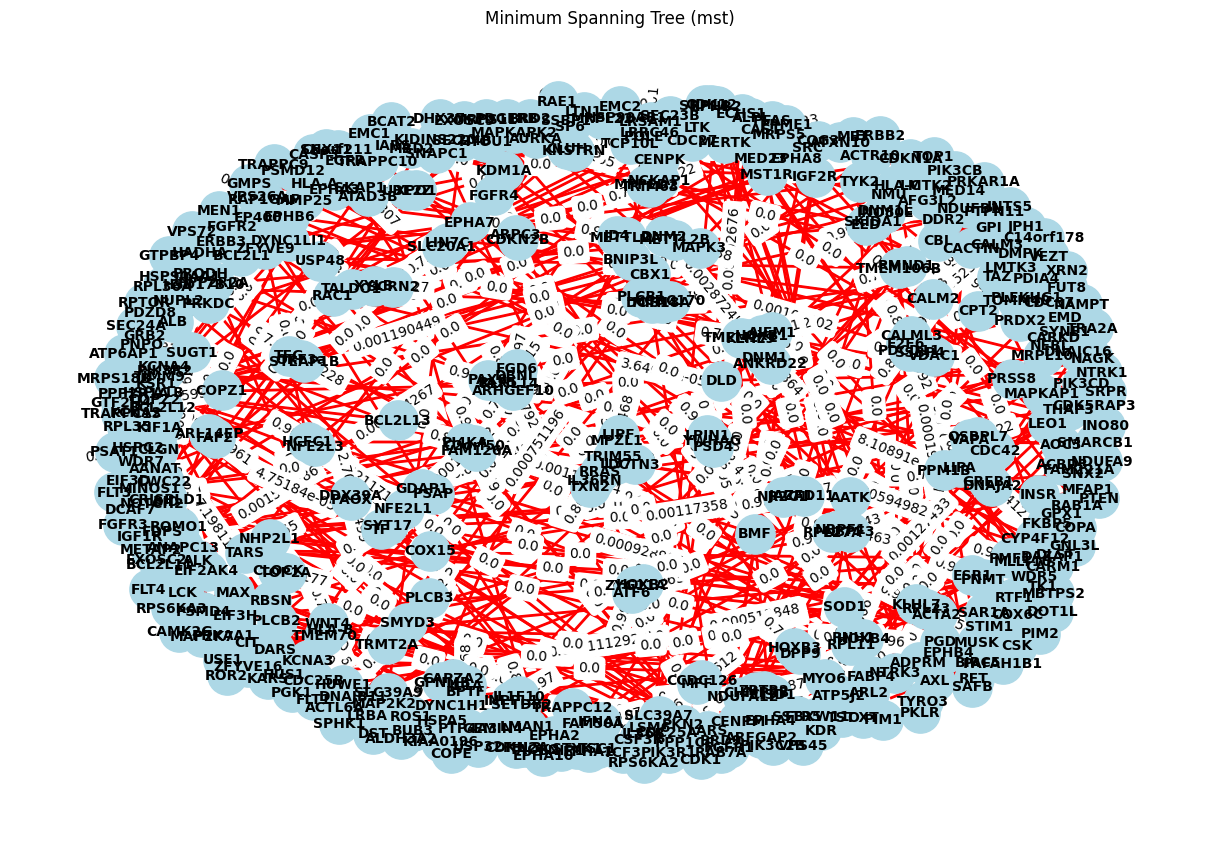

In [152]:
# Visualize the minimum spanning tree
plt.figure(figsize=(12, 8))

# Draw the minimum spanning tree mst
pos_mst = nx.spring_layout(mst)  # positions for all nodes in mst
nx.draw(mst, pos_mst, with_labels=True, node_color='lightblue', node_size=800, font_size=10, font_color='black', font_weight='bold')
nx.draw_networkx_edges(mst, pos_mst, edge_color='red', width=2)  # Draw edges of mst in red

# Add edge labels to mst
edge_labels_mst = nx.get_edge_attributes(mst, 'weight')
nx.draw_networkx_edge_labels(mst, pos_mst, edge_labels=edge_labels_mst)

plt.title("Minimum Spanning Tree (mst)")
plt.show()